# Import modules

In [45]:
# Import the required module
pip install fastapi uvicorn
pip install streamlit

import pickle
import pandas as pd
import numpy as np
from collections import defaultdict
from ast import literal_eval
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Data prepocessing

In [46]:
df = pd.read_csv("synthetic_fraud_data.csv")

# Drop unnecessary columns
columns_to_drop = [
    'card_number', 'currency', 'device', 'device_fingerprint', 
    'ip_address', 'high_risk_merchant', 'is_fraud'
]

df_cleaned = df.drop(columns=columns_to_drop)

# Display the first few rows after dropping
df_cleaned.head()

df_cleaned["timestamp"] = pd.to_datetime(df_cleaned["timestamp"], format='mixed')


# Extract date-based features
df_cleaned['transaction_day'] = df_cleaned['timestamp'].dt.day
df_cleaned['transaction_weekday'] = df_cleaned['timestamp'].dt.weekday  # 0=Monday, 6=Sunday
df_cleaned['transaction_month'] = df_cleaned['timestamp'].dt.month

# Extract 'velocity_last_hour' JSON-like data into separate columns
df_cleaned['velocity_last_hour'] = df_cleaned['velocity_last_hour'].apply(literal_eval)  # Convert string to dictionary



# Extract features from 'velocity_last_hour'
df_cleaned['num_transactions_last_hour'] = df_cleaned['velocity_last_hour'].apply(lambda x: x.get('num_transactions', 0))
df_cleaned['total_spent_last_hour'] = df_cleaned['velocity_last_hour'].apply(lambda x: x.get('total_amount', 0))


# Drop the original 'velocity_last_hour' column
df_cleaned = df_cleaned.drop(columns=['velocity_last_hour'])



# Select categorical columns to encode
categorical_columns = ['merchant_category', 'merchant_type', 'merchant', 'city', 'city_size', 'card_type', 'channel']

# Apply Label Encoding to categorical columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoders[col] = le  # Store encoder for future reference

# Select numerical columns for normalization
numerical_columns = ['amount', 'distance_from_home', 'num_transactions_last_hour', 'total_spent_last_hour']

# Apply Min-Max Scaling to normalize numerical data
scaler = MinMaxScaler()
df_cleaned[numerical_columns] = scaler.fit_transform(df_cleaned[numerical_columns])

df_cleaned.to_csv("data.csv")


# Fit

In [27]:
df_cleaned2 = df_cleaned

In [28]:
features_for_model = ['amount', 'merchant_category', 'merchant_type', 'num_transactions_last_hour', 'total_spent_last_hour']

# # Train Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)  # 5% transactions marked as anomalies
df_cleaned['overspending_flag'] = iso_forest.fit_predict(df_cleaned[features_for_model])

with open("isolation_forest_model.pkl", "wb") as model_file:
    pickle.dump(iso_forest, model_file)


In [29]:
# # Select relevant features for anomaly detection
features_for_model = ['amount', 'merchant_category', 'merchant_type', 'num_transactions_last_hour', 'total_spent_last_hour']

# # Train Isolation Forest model
iso_forest2 = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)  # 5% transactions marked as anomalies

df_cleaned2['overspending_flag'] = iso_forest2.fit_predict(df_cleaned2[features_for_model])


# # Convert output: -1 (Anomaly) → 1 (Overspending), 1 (Normal) → 0 (Normal Spending)
df_cleaned2['overspending_flag'] = df_cleaned2['overspending_flag'].apply(lambda x: 1 if x == -1 else 0)



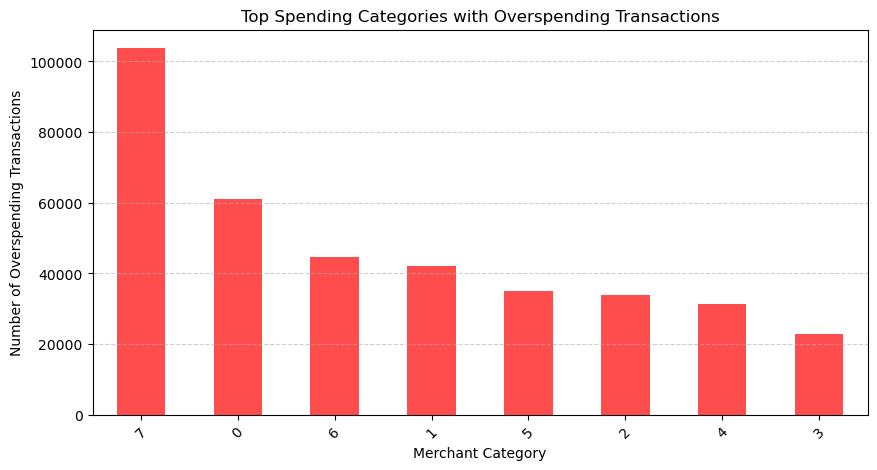

4.999982629066702

In [30]:
# 1️⃣ Calculate overall overspending rate
total_transactions = df_cleaned.shape[0]
overspending_transactions = df_cleaned['overspending_flag'].sum()
overspending_rate = (overspending_transactions / total_transactions) * 100

# 2️⃣ Identify top categories with overspending transactions
top_overspending_categories = df_cleaned[df_cleaned['overspending_flag'] == 1] \
    .groupby('merchant_category')['overspending_flag'] \
    .count() \
    .sort_values(ascending=False)

# Plot top overspending categories
plt.figure(figsize=(10, 5))
top_overspending_categories.head(10).plot(kind='bar', color='red', alpha=0.7)
plt.title("Top Spending Categories with Overspending Transactions")
plt.xlabel("Merchant Category")
plt.ylabel("Number of Overspending Transactions")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# Display overall overspending rate
overspending_rate


In [42]:
label_encoders['merchant_category'].inverse_transform([7, 0,6,1,5,2,4,3])

array(['Travel', 'Education', 'Retail', 'Entertainment', 'Restaurant',
       'Gas', 'Healthcare', 'Grocery'], dtype=object)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__text_signature__']